In [1]:
# ライブラリ
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import torch
import torchvision
from torchvision import transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torch.nn import init

from torchvision import models
from torchvision.models.vgg import VGG16_Weights

from functools import partial
from PIL import Image
import time
import cv2
import os


In [23]:
# CPUかGPUか動的に決める
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
def learn(model, train_loader, val_loader, optimizer, loss_func, num_epoch, early_stopping=None, save_path=None, scheduler=None):
    """
    Train and validate a given PyTorch model.
    
    Parameters:
    - model: PyTorch model to train. Model needs to be on GPU beforehand if it's supposed to be trained on GPU.
    - train_loader: DataLoader for training data.
    - val_loader: DataLoader for validation data.
    - optimizer: PyTorch optimizer.
    - loss_func: PyTorch loss function.
    - num_epoch: Number of epochs for training.
    - early_stopping: Number of epochs with no improvement to stop training. None means no early stopping.
    - save_path: Path to save the best model.
    - scheduler: Learning rate scheduler. None means no scheduler.
    
    Returns:
    - train_losses: List of training losses.
    - val_losses: List of validation losses.
    - val_accuracies: List of validation accuracies.
    """
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    no_improve = 0 # カウント用変数
    
    for epoch in range(num_epoch):
        model.train()
        running_loss = 0.0
        running_val_loss = 0.0
        running_val_acc = 0.0
        
        for train_batch, data in tqdm(enumerate(train_loader), total=len(train_loader), desc="Training", leave=False):
            
            X, y = data
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            # forward
            preds = model(X)
            loss = loss_func(preds, y)
            running_loss += loss.item()
    
            # backward
            loss.backward()
            optimizer.step()
            
        model.eval()
        # validation
        with torch.no_grad():
            for val_batch, data in tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation", leave=False):
                X_val, y_val = data
                X_val, y_val = X_val.to(device), y_val.to(device)
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]
                running_val_acc += val_accuracy.item()
    
        train_losses.append(running_loss/(train_batch + 1))
        val_losses.append(running_val_loss/(val_batch + 1))
        val_accuracies.append(running_val_acc/(val_batch + 1))
        print(f'epoch: {epoch}: train error: {train_losses[-1]}, validation error: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}')
    
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve = 0
            if save_path is not None:
                state = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_losses[-1]
                }
                torch.save(state, save_path)
        else:
            no_improve += 1
    
        if early_stopping and no_improve >= early_stopping:
            print('Stopping early')
            break
        if scheduler:
            scheduler.step()

    return train_losses, val_losses, val_accuracies

In [14]:

class ActivationStatistics:

    def __init__(self, model):
        self.model = model
        self.act_means = [ [] for module in self.model if isinstance(module, nn.ReLU)]
        self.act_stds = [ [] for module in self.model if isinstance(module, nn.ReLU)]
        self.register_hook()

    def register_hook(self):
        relu_layers = [module for module in self.model if isinstance(module, nn.ReLU)]
        for i, relu in enumerate(relu_layers):
            relu.register_forward_hook(partial(self.save_out_stats, i))

    def save_out_stats(self, i, module, inp, out):
        # relu層からout(mean, std)は計算グラフを作成するので、計算グラフを作成しない処理 -> detach
        # detachをするとCPUで学習するので、明示的にCPUで処理するようにする。
        self.act_means[i].append(out.detach().cpu().mean().item())
        self.act_stds[i].append(out.detach().cpu().std().item())

    def get_statstics(self):
        return self.act_means, self.act_stds

    def plot_statistics(self):
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        for act_mean in self.act_means:
            axs[0].plot(act_mean)
        axs[0].set_title('Activation means')
        plt.legend(range(len(self.act_means)))
        

        for act_std in self.act_stds:
            axs[1].plot(act_std)
        axs[1].set_title('Activation means')
        plt.legend(range(len(self.act_stds)))
        
        plt.show()

In [15]:

class DogCatDataset(Dataset):
    def __init__(self, cifar_dataset, indices):
        self.cifar_dataset = cifar_dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        original_idx = self.indices[idx]
        image, label = self.cifar_dataset[original_idx]
        # CIFAR-10のラベル 'cat': 3, 'dog': 5 を 'dog': 0, 'cat': 1 に変換
        if label == 3:
            label = 1  # Cat
        elif label == 5:
            label = 0  # Dog
        return image, label


In [16]:
# データの準備

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./cifar10_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10(root='./cifar10_data', download=True, transform=transform)

classes = {}
for index, class_name, in enumerate(train_dataset.classes):
    classes[index] = class_name

# 犬と猫だけのindexを抽出
dog_cat_train_index = [i for i, (image, label) in enumerate(train_dataset) if label in (3, 5)]
dog_cat_val_index = [i for i, (image, label) in enumerate(val_dataset) if label in (3, 5)]

train_dog_cat_dataset = DogCatDataset(train_dataset, dog_cat_train_index)
val_dog_cat_dataset = DogCatDataset(val_dataset, dog_cat_val_index)

# データローダーの作成
train_loader = DataLoader(train_dog_cat_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dog_cat_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
# 簡易的なモデルを作成する
conv_model = nn.Sequential(
    # 第1層目 3x32x32
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    # ２層目16x16x16
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    # 第３層目 32x8x8
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    # 第4層目 64x4x4
    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    # Adaptive層
    nn.AdaptiveAvgPool2d(1),
    # 第5層
    # フラット化と全結合層を調整
    nn.Flatten(),  # 特徴を1次元に展開
    nn.Linear(128, 64),  # 中間層のユニット数を減らし、猫と犬の分類に特化
    nn.ReLU(),
    nn.Linear(64, 2)  # 最終出力層のクラス数を2に設定
)


In [19]:
# 作成したmodelで学習を行う
act_stat = ActivationStatistics(conv_model)
opt = optim.Adam(conv_model.parameters(), lr=0.001)
loss_func = F.cross_entropy
num_epoch = 10
train_losses, val_losses, val_accuracies = learn(conv_model, train_loader, val_loader, opt, loss_func, num_epoch)


Training:   0%|          | 0/313 [00:00<?, ?it/s]

epoch: 0: train error: 0.6465409198127234, validation error: 0.5846961334871408, validation accuracy: 0.6883985623003195


epoch: 1: train error: 0.5804799647567371, validation error: 0.518958294353546, validation accuracy: 0.7470047923322684


KeyboardInterrupt: 

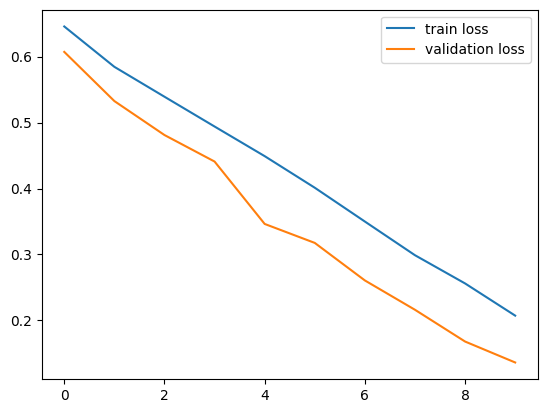

In [13]:
# 学習曲線を書く
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

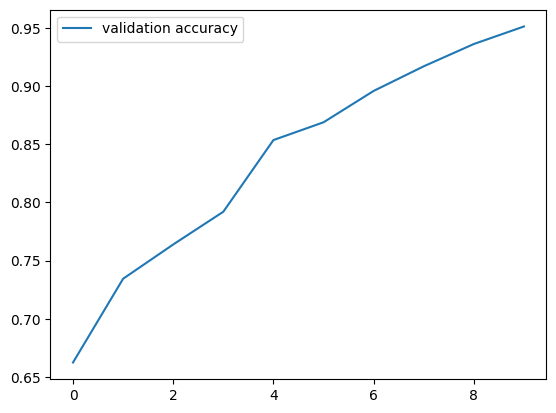

In [14]:
# Accuracyの可視化
plt.plot(val_accuracies, label='validation accuracy')
plt.legend()

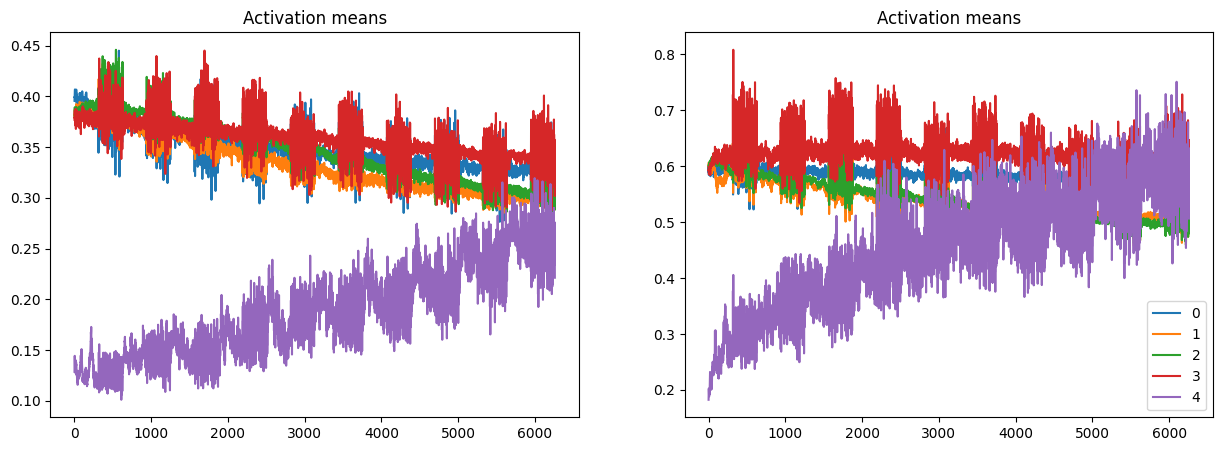

In [15]:
# Activationの統計情報をプロット
act_stat.plot_statistics()

## テスト

In [37]:

# テストデータの前処理
transform = transforms.Compose([
    # テストデータのサイズを変える
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [54]:
# 画像を読み取って前処理を適用する
image_path = 'work/data/dog2.jpg'
# PILで画像を開き, RGBに変換
image = Image.open(image_path).convert('RGB')
# transformを適用する
image = transform(image)
# unsqueeze(0)は指定した場所に、rank1を追加する
image = image.unsqueeze(0) # バッチ次元を追加[1, 3, 32, 32]

In [55]:
# モデルを評価モードにする
conv_model.eval()

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): AdaptiveAvgPool2d(output_size=1)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=128, out_features=64, bias=True)
  (15): ReLU()
  (16): Linear(in_features=64, out_features=2, bias=True)
)

In [56]:
# 画像をモデルに通して推論を行う
with torch.no_grad():
    output = conv_model(image)
    # 最も高い確率のクラスを取得
    _, predicted = torch.max(output, 1)
    # ラベルを解釈
    predicted_label = 'dog' if predicted.item() == 0 else 'cat'

In [57]:
print(f'The model predicts: {predicted_label}')


The model predicts: dog


## 本格的なモデルの作成

In [58]:
def learn(model, train_loader, val_loader, optimizer, loss_func, num_epoch, early_stopping=None, save_path=None, scheduler=None):
    """
    Train and validate a given PyTorch model.
    
    Parameters:
    - model: PyTorch model to train. Model needs to be on GPU beforehand if it's supposed to be trained on GPU.
    - train_loader: DataLoader for training data.
    - val_loader: DataLoader for validation data.
    - optimizer: PyTorch optimizer.
    - loss_func: PyTorch loss function.
    - num_epoch: Number of epochs for training.
    - early_stopping: Number of epochs with no improvement to stop training. None means no early stopping.
    - save_path: Path to save the best model.
    - scheduler: Learning rate scheduler. None means no scheduler.
    
    Returns:
    - train_losses: List of training losses.
    - val_losses: List of validation losses.
    - val_accuracies: List of validation accuracies.
    """
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    no_improve = 0 # カウント用変数
    
    for epoch in range(num_epoch):
        model.train()
        running_loss = 0.0
        running_val_loss = 0.0
        running_val_acc = 0.0
        
        for train_batch, data in tqdm(enumerate(train_loader), total=len(train_loader), desc="Training", leave=False):
            
            X, y = data
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            # forward
            preds = model(X)
            loss = loss_func(preds, y)
            running_loss += loss.item()
    
            # backward
            loss.backward()
            optimizer.step()
            
        model.eval()
        # validation
        with torch.no_grad():
            for val_batch, data in tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation", leave=False):
                X_val, y_val = data
                X_val, y_val = X_val.to(device), y_val.to(device)
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]
                running_val_acc += val_accuracy.item()
    
        train_losses.append(running_loss/(train_batch + 1))
        val_losses.append(running_val_loss/(val_batch + 1))
        val_accuracies.append(running_val_acc/(val_batch + 1))
        print(f'epoch: {epoch}: train error: {train_losses[-1]}, validation error: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}')
    
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve = 0
            if save_path is not None:
                state = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_losses[-1]
                }
                torch.save(state, save_path)
        else:
            no_improve += 1
    
        if early_stopping and no_improve >= early_stopping:
            print('Stopping early')
            break
        if scheduler:
            scheduler.step()

    return train_losses, val_losses, val_accuracies

In [59]:

class ActivationStatistics:

    def __init__(self, model):
        self.model = model
        self.act_means = [ [] for module in self.model if isinstance(module, nn.ReLU)]
        self.act_stds = [ [] for module in self.model if isinstance(module, nn.ReLU)]
        self.register_hook()

    def register_hook(self):
        relu_layers = [module for module in self.model if isinstance(module, nn.ReLU)]
        for i, relu in enumerate(relu_layers):
            relu.register_forward_hook(partial(self.save_out_stats, i))

    def save_out_stats(self, i, module, inp, out):
        # relu層からout(mean, std)は計算グラフを作成するので、計算グラフを作成しない処理 -> detach
        # detachをするとCPUで学習するので、明示的にCPUで処理するようにする。
        self.act_means[i].append(out.detach().cpu().mean().item())
        self.act_stds[i].append(out.detach().cpu().std().item())

    def get_statstics(self):
        return self.act_means, self.act_stds

    def plot_statistics(self):
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        for act_mean in self.act_means:
            axs[0].plot(act_mean)
        axs[0].set_title('Activation means')
        plt.legend(range(len(self.act_means)))
        

        for act_std in self.act_stds:
            axs[1].plot(act_std)
        axs[1].set_title('Activation means')
        plt.legend(range(len(self.act_stds)))
        
        plt.show()

In [60]:

# dogとcatのデータセットを作成する
class DogCatDataset(Dataset):
    def __init__(self, cifar_dataset, indices):
        self.cifar_dataset = cifar_dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        original_idx = self.indices[idx]
        image, label = self.cifar_dataset[original_idx]
        # CIFAR-10のラベル 'cat': 3, 'dog': 5 を 'dog': 0, 'cat': 1 に変換
        if label == 3:
            label = 1  # Cat
        elif label == 5:
            label = 0  # Dog
        return image, label


In [70]:
# データの準備

augmentation_transforms = transforms.Compose([
    # データをランダム水平反転
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),  # 画像をランダムに回転

    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./cifar10_data', train=True, download=True, transform=augmentation_transforms)
val_dataset = torchvision.datasets.CIFAR10(root='./cifar10_data', download=True, transform=augmentation_transforms)

classes = {}
for index, class_name, in enumerate(train_dataset.classes):
    classes[index] = class_name

# 犬と猫だけのindexを抽出
dog_cat_train_index = [i for i, (image, label) in enumerate(train_dataset) if label in (3, 5)]
dog_cat_val_index = [i for i, (image, label) in enumerate(val_dataset) if label in (3, 5)]

train_dog_cat_dataset = DogCatDataset(train_dataset, dog_cat_train_index)
val_dog_cat_dataset = DogCatDataset(val_dataset, dog_cat_val_index)

# データローダーの作成
train_loader = DataLoader(train_dog_cat_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dog_cat_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# modelを作成する(VGG16)を利用する
# VGG16モデルの作成
model = models.vgg16(pretrained=True)


/usr/local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:11<00:00, 47.1MB/s] 


In [ ]:
# 簡易的なモデルを作成する
conv_model = nn.Sequential(
    # 第1層目 3x32x32
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    # ２層目16x16x16
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    # 第３層目 32x8x8
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    # 第4層目 64x4x4
    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    # Adaptive層
    nn.AdaptiveAvgPool2d(1),
    # 第5層
    # フラット化と全結合層を調整
    nn.Flatten(),  # 特徴を1次元に展開
    nn.Linear(128, 64),  # 中間層のユニット数を減らし、猫と犬の分類に特化
    nn.ReLU(),
    nn.Linear(64, 2)  # 最終出力層のクラス数を2に設定
)


In [20]:
# モデルをClassで作成する
class DogCatClassificationModel(nn.Module):

    def __init__(self, in_ch):

        super(DogCatClassificationModel, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, 16, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.adaptive = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 2)

    # forward
    def forward(self, X):
        X = F.relu(self.bn1(self.conv1(X)))
        X = F.relu(self.bn2(self.conv2(X)))
        X = F.relu(self.bn3(self.conv3(X)))
        X = F.relu(self.bn4(self.conv4(X)))
        X = self.adaptive(X)
        X = self.flatten(X)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return X

model = DogCatClassificationModel(in_ch=3)



In [22]:
# 学習させてみる
opt = optim.Adam(model.parameters(), lr=0.001)
loss_func = F.cross_entropy
num_epoch = 10
start_time = time.time()
train_losses, val_losses, val_accuracies = learn(model, train_loader, val_loader, opt, loss_func, num_epoch)
end_time = time.time()
print('かかった時間:', end_time - start_time)

epoch: 0: train error: 0.6371283757800873, validation error: 0.5763086762291174, validation accuracy: 0.7013777955271565


KeyboardInterrupt: 

## テスト


In [24]:
# モデルをテストしてみる

def test_model(model, test_loader, device):
    # モデルを評価モード
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        

In [2]:
# テストデータの前処理
transform_test = transforms.Compose([
    # テストデータのサイズを変える
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# ディレクトリ内での画像ファイルでの予測
dir_path = 'work/data/
